# Notebook 2: Pre-processing & modelling


[Pre-processing](#preprocessing)

[Model 1: Naive Bayes](#naive_bayes)

[Model 2: Logistic Regression](#log_reg)

In [1]:
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Importing Data
df = pd.read_csv('cleaned_data.csv')
df.drop(columns = 'Unnamed: 0', inplace = True) 
df.shape

(1830, 3)

<a id='preprocessing'></a>

## Pre-processing: Removing html, non-letters, Regex/removing punctuation, removing stop words, Tokenising, Lemmatizing/Stemming

In [7]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words. The input is a single string (a raw reddit review), and 
    # the output is a single string (a preprocessed reddit review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Stemming. Lemmatizing was also done but model performance fared worse.
    p_stemmer = PorterStemmer()
    stem_spam = [p_stemmer.stem(i) for i in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(stem_spam))


In [8]:
total_reviews = df.shape[0]
print(f'There are {total_reviews} reviews.')

clean_combined_reviews = []

for review in df['content']:
    clean_combined_reviews.append(review_to_words(review))

cleaned = pd.DataFrame(data = clean_combined_reviews, columns = ['clean_content'])
df_clean = df.join(cleaned, how='left')

There are 1830 reviews.


In [9]:
df_clean.head()

,content,subreddit_Fantasy,clean_content
0,Are there more books planned for the Licanius ...,1,book plan licaniu seri discov trilog past fall...
1,Grimdark coming of age booksI have read many b...,1,grimdark come age booksi read mani book found ...
2,Fantasy tropes from another POVReading Expanse...,1,fantasi trope anoth povread expans realis adol...
3,How long does it take to get into the Wanderin...,1,long take get wander inn hi everyon recent sta...
4,What's some dark/gothic fantasy that is *not* ...,1,dark gothic fantasi grimdark read bram stoker ...


## Customised Stopwords

In [30]:
own_stopwords = ['www', 'http', 'fantasy', 'fantasi', 'scifi','printsf', 'sf', 'book', 'one', 'thing', 'realli']

## Train/Test/Split

In [10]:
# define our X and y variables
X  = df_clean['clean_content']
y = df_clean['subreddit_Fantasy']

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.2, random_state = 50)

print(f'shape of X_train is {X_train.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_test is {y_test.shape}')


shape of X_train is (1464,)
shape of y_train is (1464,)
shape of X_test is (366,)
shape of y_test is (366,)


## Baseline Model Accuracy
We have a 54% baseline accuracy of correctly predicting a post coming from the Fantasy subreddit.

In [12]:
print(df['subreddit_Fantasy'].value_counts(normalize = True))
print(y_train.value_counts(normalize = True))

1    0.545355
0    0.454645
Name: subreddit_Fantasy, dtype: float64
1    0.545082
0    0.454918
Name: subreddit_Fantasy, dtype: float64


<a id='naive_bayes'></a>

## Model 1: Naive Bayes (Multinomial Bayes)
Multinomial Bayes was chosen as CountVectorizer can return integers. We will build a pipeline consisting of CountVectorizer, followed by LogisticRegression.


In [13]:
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('nb', MultinomialNB()),
])

In [14]:
# Gridsearch over CountVectorizer and Naive Bayes
pipe_params = {
    'vec__stop_words' : [own_stopwords],
    'vec__max_features': [1000, 1500, 2000, 2500, 3000],
    'vec__min_df': [0.01, .05, .1, .2],
    'vec__max_df': [0.7, .8, .9],
    'vec__ngram_range': [(1,1), (1,2), (1,3)]      # check both single grams and bi-grams 
}

gs_nb = GridSearchCV(pipe, param_grid = pipe_params, cv = 5, verbose = 1)
gs_nb.fit(X_train, y_train)

print(gs_nb.best_score_)
gs_nb.best_params_  

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 13.6min finished


0.8306010928961749


{'vec__max_df': 0.7,
 'vec__max_features': 2000,
 'vec__min_df': 0.01,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': ['www',
  'http',
  'fantasy',
  'scifi',
  'printsf',
  'sf',
  'book',
  'one',
  'thing',
  'realli']}

In [15]:
# Instantiate our CountVectorizer & Naive Bayes with the best parameters found from GridSearch

best_pipe_nb = Pipeline([
    ('vec', CountVectorizer(max_features = 1500, max_df = 0.7, min_df = 0.01, stop_words = own_stopwords, ngram_range = (1,1))),
    ('nb', MultinomialNB())
])

best_pipe_nb.fit(X_train, y_train)

print(f' Accuracy score on training data is {best_pipe_nb.score(X_train, y_train)}')
print(f' Accuracy score on testing data is {best_pipe_nb.score(X_test, y_test)}')

 Accuracy r^2 score on training data is 0.8845628415300546
 Accuracy r^2 score on testing data is 0.860655737704918


In [16]:
# exploring the top words identified by the model as features
#best_pipe_nb.steps[0][1].get_feature_names()

In [35]:
# seeing the top features from the subreddits in a dataframe
vec_nb = best_pipe_nb.steps[0][1]
X_train_vec_nb = pd.DataFrame(vec_nb.fit_transform(X_train).todense(),
                          columns = vec_nb.get_feature_names())
X_test_vec_nb = pd.DataFrame(vec_nb.fit_transform(X_test).todense(),
                          columns = vec_nb.get_feature_names())
X_train_vec_nb.head()

,abercrombi,abil,abl,absolut,abus,ac,accept,access,account,accur,...,written,wrong,wrote,ya,ye,yeah,year,yet,young,youtub
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
best_pipe_nb.steps[0][1]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.7, max_features=1500, min_df=0.01,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['www', 'http', 'fantasy', 'scifi', 'printsf', 'sf',
                            'book', 'one', 'thing', 'realli'],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [34]:
# Seeing which are the important words for 
# prob for positive class
pos_class_prob_sorted = best_pipe_nb.steps[1][1].feature_log_prob_[0,:].argsort()

# prob for positive class
neg_class_prob_sorted = best_pipe_nb.steps[1][1].feature_log_prob_[1,:].argsort()

# getting top features for sci fi and fantasy
sf_top_features = np.take(best_pipe_nb.steps[0][1].get_feature_names(), neg_class_prob_sorted)
f_top_features = np.take(best_pipe_nb.steps[0][1].get_feature_names(), pos_class_prob_sorted)

print(f'List of science fiction top words: \n{sf_top_features[:50]}')
print(f'List of fantasy top words: \n {f_top_features[:50]}')

List of science fiction top words: 
['elabor' 'backstori' 'bit' 'way' 'robert' 'wiki' 'overal' 'hang' 'green'
 'around' 'gift' 'plant' 'expand' 'planet' 'burn' 'approach' 'haunt'
 'hyperion' 'scream' 'chiang' 'org' 'could' 'meaningless' 'conclus' 'arc'
 'enough' 'wife' 'scientif' 'engin' 'tortur' 'steven' 'quest' 'rec' 'end'
 'ador' 'mainli' 'antholog' 'command' 'jim' 'introduc' 'compel' 'caught'
 'villag' 'area' 'anticip' 'soft' 'quickli' 'orc' 'refer' 'watch']
List of fantasy top words: 
 ['aaron' 'beyond' 'fail' 'per' 'palac' 'creatur' 'narr' 'preview' 'moment'
 'hold' 'rule' 'major' 'made' 'lock' 'jemisin' 'militari' 'gem' 'knowledg'
 'friend' 'skin' 'promis' 'gain' 'wizard' 'form' 'across' 'defin' 'measur'
 'despit' 'rate' 'religi' 'die' 'bloodi' 'longest' 'divers' 'appeal' 'saw'
 'said' 'learn' 'top' 'track' 'antagonist' 'rank' 'lose' 'stupid' 'ship'
 'commun' 'bonu' 'practic' 'sit' 'promin']


<a id='log_reg'></a>

## Model 2: Logistic Regression

In [24]:
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [25]:
# Gridsearch over CountVectorizer and Naive Bayes
pipe_params = {
    'vec__stop_words' : [own_stopwords],
    'vec__max_features': [1000, 1500, 2000, 2500, 3000],
    'vec__min_df': [0.01, .05, .1],
    'vec__max_df': [0.6, 0.7, .8, .9],
    'vec__ngram_range': [(1,1), (1,2), (1,3)]      # check single grams, bi-grams & tri-grams
}

gs_lr = GridSearchCV(pipe, param_grid = pipe_params, cv = 5, verbose = 1)
gs_lr.fit(X_train, y_train)

print(gs_lr.best_score_)
gs_lr.best_params_  

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 13.2min finished


0.842896174863388


{'vec__max_df': 0.6,
 'vec__max_features': 2000,
 'vec__min_df': 0.01,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': ['www',
  'http',
  'fantasy',
  'scifi',
  'printsf',
  'sf',
  'book',
  'one',
  'thing',
  'realli']}

In [26]:
# Instantiate our CountVectorizer with the best parameters found from GridSearch

best_pipe = Pipeline([
    ('vec', CountVectorizer(max_features = 2000, max_df = 0.7, min_df = 0.01, stop_words = own_stopwords, ngram_range = (1,2))),
    ('lr', LogisticRegression(solver='lbfgs'))
])

best_pipe.fit(X_train, y_train)
print(f' Accuracy r^2 score on training data is {best_pipe.score(X_train, y_train)}')
print(f' Accuracy r^2 score on testing data is {best_pipe.score(X_test, y_test)}')

 Accuracy r^2 score on training data is 0.9979508196721312
 Accuracy r^2 score on testing data is 0.8497267759562842


# Visualising the features from CountVectoriser

There are 1148596 words in all the reviews.


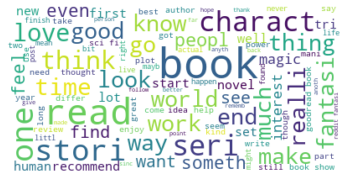

In [38]:
# Start with one review:
#text = X_train.iloc[0]
text = " ".join(review for review in X_train)
print ("There are {} words in all the reviews.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('first_review.jpeg')